In [172]:
import pandas as pd
import pandas_ta as ta

df = pd.read_csv('downloads/mt/EURUSD_M5_201001040000_202410170705.csv', sep="\\t")
df['Gmt time'] = df['<DATE>'] + ' ' + df['<TIME>']


df.rename(columns={'<CLOSE>' : 'Close', '<HIGH>': 'High', '<OPEN>' : 'Open', '<LOW>':'Low'}, inplace=True)
# df = pd.read_csv("EURUSD_Candlestick_5_M_ASK_30.09.2019-30.09.2022.csv")
df["Gmt time"]=df["Gmt time"].str.replace(".000","")
df['Gmt time']=pd.to_datetime(df['Gmt time'],format='%Y.%m.%d %H:%M:%S')
df.drop(columns =['<DATE>', '<TIME>'], inplace=True) 
df=df[df.High!=df.Low]
df.set_index("Gmt time", inplace=True)
df.drop(columns=['<TICKVOL>', '<SPREAD>', '<VOL>'], inplace=True)

df.shape

(1099300, 4)

In [173]:
def feature_engineering(df : pd.DataFrame, i : int, n :int):
        
    ema_50 = ta.ema(df.Close, length=50)
    ema_30 = ta.ema(df.Close, length=30)
    rsi_14 = ta.rsi(df.Close, length=14)
    cci = ta.cci(df['High'], df['Low'], df['Close'], window=20, constant=0.015)
    my_bbands = ta.bbands(df.Close, length=15, std=1.5)
    atr_10 = ta.atr(df.High, df.Low, df.Close, length=10)
            
    df = df.join(ema_50)
    df = df.join(ema_30)
    df = df.join(rsi_14)
    df = df.join(atr_10)
    df = df.join(cci)
    df = df.join(my_bbands)
        
    # Adding Simple Moving Averages
    df['sma5'] = ta.sma(df['Close'],window = 5)
    df['sma10'] = ta.sma(df['Close'],window = 10)
    df['sma15'] = ta.sma(df['Close'],window = 15)
    df['sma20'] = ta.sma(df['Close'],window = 20)
    df['sma30'] = ta.sma(df['Close'],window = 30)
    df['sma50'] = ta.sma(df.Close,length=50)
    df['sma80'] = ta.sma(df['Close'],window = 80)
    df['sma100'] = ta.sma(df['Close'],window = 100)
    df['sma200'] = ta.sma(df['Close'],window = 200)

    # Adding Price to Simple Moving Averages ratios

    df['sma5_ratio'] = df['Close'] / df['sma5']
    df['sma10_ratio'] = df['Close'] / df['sma10']
    df['sma20_ratio'] = df['Close'] / df['sma20']
    df['sma30_ratio'] = df['Close'] / df['sma30']
    df['sma50_ratio'] = df['Close'] / df['sma50']
    df['sma80_ratio'] = df['Close'] / df['sma80']
    df['sma100_ratio'] = df['Close'] / df['sma100']
    df['sma200_ratio'] = df['Close'] / df['sma200']
    
    df['rsi'] = ta.rsi(df['Close'],length=14)
    df['cci'] = ta.cci(df['High'], df['Low'], df['Close'], window=20, constant=0.015)
    bb_indicator = ta.bbands(df['Close'], length=20, std=2)
    
    df=df.join(bb_indicator)
  
    
    # Adding features derived from the indicators above

    df['rsi_overbought'] = (df['rsi'] >= 70).astype(int)
    df['rsi_oversold'] = (df['rsi'] <= 30).astype(int)
    df['above_bb_high'] = (df['Close'] >= df['BBU_20_2.0']).astype(int)
    df['below_bb_low'] = (df['Close'] <= df['BBL_20_2.0']).astype(int)
    df['cci_high'] = (df['cci'] >= 120).astype(int)
    df['cci_low'] = (df['cci'] <= -120).astype(int)
   
    df['sma5 > sma10'] = (df['sma5'] > df['sma10']).astype(int)
    df['sma10 > sma15'] = (df['sma10'] > df['sma15']).astype(int)
    df['sma15 > sma20'] = (df['sma15'] > df['sma20']).astype(int)
    df['sma20 > sma30'] = (df['sma20'] > df['sma30']).astype(int)
    df['sma30 > sma50'] = (df['sma30'] > df['sma50']).astype(int)
    df['sma50 > sma80'] = (df['sma50'] > df['sma80']).astype(int)
    df['sma80 > sma100'] = (df['sma80'] > df['sma100']).astype(int)
    df['sma100 > sma200'] = (df['sma100'] > df['sma200']).astype(int)

    df['close_above_bbl_15_1.5'] = (df['Close'] >= df['BBL_15_1.5']).astype(int)
    df['close_above_bbl_20_2'] = (df['Close'] >= df['BBL_20_2.0']).astype(int)

    df['close_bellow_bbu_15_1.5'] = (df['Close'] >= df['BBU_15_1.5']).astype(int)
    
    
    # Removing NaN values from the dataframe 
    df.dropna(inplace = True)
    return df

n = 10**3
df_list = [ feature_engineering(df[i:i+n], i, i+n) for i in range(0, df.shape[0], n)]

df = pd.concat(df_list)
ichimoku_data = ta.ichimoku(df['High'], df['Low'], df['Close'], tenkan = 9, kijun = 26, senkou = 52)
df = pd.concat([df, ichimoku_data[0]], axis=1)

In [174]:
df['prev_fast_sma'] = df['sma30'].shift(1)


In [175]:
from tqdm import tqdm
import numpy as np

def find_crossover(fast_sma, prev_fast_sma, slow_sma):

    if fast_sma > slow_sma and prev_fast_sma < slow_sma:
        return 1
    elif fast_sma < slow_sma and prev_fast_sma > slow_sma:
        return 2

    return 0


tqdm.pandas()
df.reset_index(inplace=True)


df['crossover'] = np.vectorize(find_crossover)(df['sma15'], df['prev_fast_sma'], df['sma50'])


In [176]:
df.reset_index(drop=True, inplace=True)
df.set_index('Gmt time', inplace=True)

In [177]:
import numpy as np

df['NextClose'] = df['Close'].shift(-1) - df['Close']
df['close_after_5_days'] = df['Close'].diff().rolling(5).sum()
df['close_after_10_days'] = df['Close'].diff().rolling(10).sum()

conditions = [df['close_after_5_days'] < 0, df['close_after_5_days'] == 0, df['close_after_5_days'] > 0 ]
choices = [ 0, 1, 2]
df['Target'] = np.select(conditions, choices)

conditions = [df['close_after_10_days'] < 0, df['close_after_10_days'] == 0, df['close_after_10_days'] > 0 ]
choices = [ 0, 1, 2]

df['Target2'] = np.select(conditions, choices)
df.shape

(1045400, 67)

In [184]:
# import quantstats as qs

# Machine Learning 
from sklearn.metrics import roc_auc_score
import logging, sys
logging.disable(sys.maxsize)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import auc, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

df.dropna(inplace=True)
target = df['Target2']
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Target','Target2', 'NextClose', 'close_after_5_days','close_after_10_days'], axis=1), target, test_size=.3)

sc = MinMaxScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

classifiers = [
    # XGBClassifier(random_state = 42),
    # LGBMClassifier(random_state = 42),
    # AdaBoostClassifier(random_state = 42, n_estimators=45, algorithm='SAMME.R', learning_rate=1.03),
    RandomForestClassifier(random_state = 42, max_depth=30,min_samples_leaf=20, n_estimators=7)
]

#  Iterating over classifiers in the list above, training, and evaluating them
k_folds = KFold(n_splits = 5)

for clf in classifiers:
    scores = cross_val_score(clf, X_train_scaled, y_train, cv = k_folds)
    
    clf.fit(X_train_scaled, y_train)
    
    y_pred = clf.predict(X_test_scaled)
    print(f'{type(clf).__name__}: Accuracy Score={accuracy_score(y_test, y_pred):.6f}')
    print(f'{type(clf).__name__}: Mean KFold={scores.mean():.6f}')
    print(f'{type(clf).__name__}: Max KFold={scores.max():.6f}')



feature_importances = pd.DataFrame(classifiers[0].feature_importances_, index=X_train.columns, columns=['Importance']).sort_values('Importance', ascending=False)

RandomForestClassifier: Accuracy Score=0.892468
RandomForestClassifier: Mean KFold=0.892707
RandomForestClassifier: Max KFold=0.894261


In [190]:
#finding top features
top_feature = feature_importances[feature_importances.Importance > .01]
df_with_top_feature = df[top_feature.index]
print(top_feature)
X_train, X_test, y_train, y_test = train_test_split(df_with_top_feature, target, test_size=.3)

sc = MinMaxScaler()
X_train_scaled_top_feature = sc.fit_transform(X_train)
X_test_scaled_top_feature = sc.transform(X_test)

random_forest_model = RandomForestClassifier( min_samples_split=70, max_depth=20, n_estimators=45);

random_forest_model.fit(X_train_scaled_top_feature, y_train)
y_pred = random_forest_model.predict(X_test_scaled_top_feature)

print(f'{type(random_forest_model).__name__}: Accuracy Score={accuracy_score(y_test, y_pred):.6f}')

trees = random_forest_model.estimators_

# ذخیره درختان به صورت متنی
with open("rf_trees.txt", "w") as f:
    for i, tree in enumerate(trees):
        f.write(f"Tree {i}:\n")
        f.write(str(tree) + "\n")

                        Importance
CCI_14_0.015              0.224526
sma200_ratio              0.146238
sma20_ratio               0.083808
cci                       0.080672
sma10_ratio               0.074916
BBP_15_1.5                0.074418
rsi                       0.057403
BBP_20_2.0                0.056811
sma50_ratio               0.053341
RSI_14                    0.030791
close_above_bbl_15_1.5    0.030014
RandomForestClassifier: Accuracy Score=0.895280


In [181]:
df[feature_importances[feature_importances.Importance > .01].index]

,sma200_ratio,sma20_ratio,sma10_ratio,sma5_ratio,CCI_14_0.015,close_above_bbl_15_1.5,sma50_ratio,cci,sma80_ratio,sma100_ratio,sma30_ratio,BBP_15_1.5,BBB_15_1.5,ATRr_10
Gmt time,,,,,,,,,,,,,,
2010-01-04 10:30:00,1.001928,1.001928,1.001928,1.001928,151.700166,1,1.004527,151.700166,1.001928,1.001928,1.001928,1.213425,0.375010,0.000999
2010-01-04 10:35:00,1.002107,1.002107,1.002107,1.002107,196.128517,1,1.004952,196.128517,1.002107,1.002107,1.002107,1.191557,0.416189,0.001078
2010-01-04 10:40:00,1.001673,1.001673,1.001673,1.001673,163.483560,1,1.004696,163.483560,1.001673,1.001673,1.001673,1.078117,0.412216,0.001053
2010-01-04 10:45:00,1.001140,1.001140,1.001140,1.001140,114.377227,1,1.004306,114.377227,1.001140,1.001140,1.001140,0.952788,0.399831,0.001009
2010-01-04 10:50:00,1.001382,1.001382,1.001382,1.001382,108.507848,1,1.004724,108.507848,1.001382,1.001382,1.001382,1.008059,0.402956,0.001011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-17 04:35:00,1.000075,1.000075,1.000075,1.000075,13.271081,1,1.000174,13.271081,1.000075,1.000075,1.000075,0.776220,0.028665,0.000191
2024-10-17 04:40:00,1.000138,1.000138,1.000138,1.000138,105.628059,1,1.000247,105.628059,1.000138,1.000138,1.000138,0.967547,0.030850,0.000191
2024-10-17 04:45:00,1.000072,1.000072,1.000072,1.000072,53.081458,1,1.000175,53.081458,1.000072,1.000072,1.000072,0.715985,0.031259,0.000196


<Axes: >

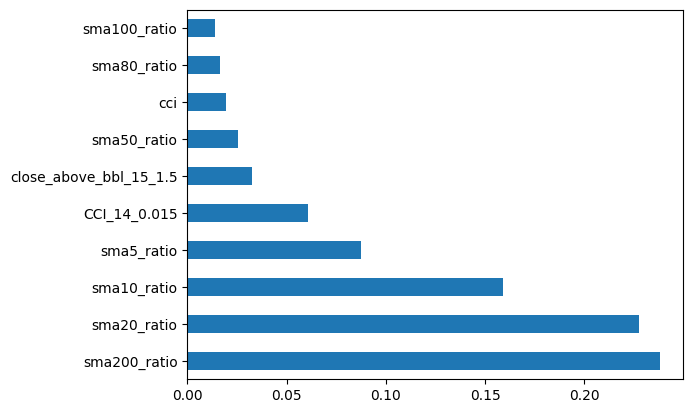

In [182]:
(pd.Series(classifiers[0].feature_importances_, index=df.drop(columns=['Target', 'Target2', 'close_after_10_days', 'NextClose', 'close_after_5_days'], axis=1).columns).nlargest(10).plot(kind='barh'))

In [ ]:
import matplotlib.pyplot as plt
from sklearn import tree
%matplotlib inline
fn=df.drop(columns=['Target', 'NextClose'], axis=1).columns
cn=['Target']

fig, axes = plt.subplots(nrows = 5,ncols = 1,figsize = (4,2), dpi=900)


for item in range(0,5):
    tree.plot_tree(classifiers[0].estimators_[item],
                   feature_names = fn,filled = True,ax = axes[item]);



# Hyperparamter Tuning For AdaBoost Classifier

In [186]:
from sklearn.model_selection import train_test_split

df.dropna(inplace=True)
target = df['Target2']
X_train, X_test, y_train, y_test = train_test_split(df[feature_importances[feature_importances.Importance > .01].index], target, test_size=.3)


sc = MinMaxScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

from utils.lwoku import RANDOM_STATE, N_JOBS, VERBOSE, get_prediction
from utils.grid_search_utils import plot_grid_search, table_grid_search

import pickle
ab_clf = AdaBoostClassifier(random_state=RANDOM_STATE)
parameters = {
    'n_estimators': [15, 20, 30, 40, 45, 50],
    'learning_rate': [(0.97 + x / 100) for x in range(0, 8)],
    'algorithm': ['SAMME', 'SAMME.R']
}
clf = GridSearchCV(ab_clf, parameters, verbose=VERBOSE, n_jobs=N_JOBS)
clf.fit(X_train_scaled, y_train)

plot_grid_search(clf)
table_grid_search(clf)

with open('adaboost.pickle', 'wb') as fp:
    pickle.dump(clf, fp)

,mean_test_score,mean_fit_time,mean_score_time,param_algorithm,param_learning_rate,param_n_estimators
89,0.888604,100.470035,1.53105,SAMME.R,1.03,50


AdaBoostClassifier(learning_rate=1.03, n_estimators=45, random_state=42)

### Hyper Parameter Tuning RandomForest Classifier

In [ ]:
from sklearn.model_selection import train_test_split

df.dropna(inplace=True)
target = df['Target2']
X_train, X_test, y_train, y_test = train_test_split(df[feature_importances[feature_importances.Importance > .01].index], target, test_size=.3)


sc = MinMaxScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV

from utils.lwoku import RANDOM_STATE, N_JOBS, VERBOSE, get_prediction
from utils.grid_search_utils import plot_grid_search, table_grid_search

import pickle
ab_clf = RandomForestClassifier(random_state=RANDOM_STATE)
parameters = {
    'n_estimators': [40, 45, 50],
    'max_depth' : [10,20,30],
    'min_samples_split':[30,50,70]
}
clf = GridSearchCV(ab_clf, parameters, verbose=VERBOSE, n_jobs=N_JOBS)
clf.fit(X_train_scaled_top_feature, y_train)

y_pred = clf.predict(X_test_scaled_top_feature)

print("acc score : ", accuracy_score(y_test, y_pred))
plot_grid_search(clf)
table_grid_search(clf)

with open('randomforest.pickle', 'wb') as fp:
    pickle.dump(clf, fp)

In [91]:
    df.head()

,Open,High,Low,Close,EMA_50,EMA_30,RSI_14,ATRr_10,CCI_14_0.015,BBL_15_1.5,...,ITS_9,IKS_26,ICS_26,prev_fast_sma,crossover,NextClose,close_after_5_days,close_after_10_days,Target,Target2
Gmt time,,,,,,,,,,,,,,,,,,,,,
2014-01-09 06:00:00,1.35788,1.35905,1.35770,1.35876,1.360067,1.359094,48.720855,0.001230,126.391202,1.356772,...,1.357850,1.359410,1.36122,1.357712,0,0.00061,0.00126,0.00071,2,2
2014-01-09 07:00:00,1.35876,1.35943,1.35875,1.35937,1.360039,1.359112,52.942339,0.001175,230.281061,1.356882,...,1.358040,1.359410,1.36050,1.357783,0,0.00070,0.00154,0.00123,2,2
2014-01-09 08:00:00,1.35935,1.36011,1.35911,1.36007,1.360040,1.359174,57.287740,0.001158,216.302902,1.356696,...,1.358380,1.359320,1.35977,1.357906,0,0.00086,0.00238,0.00255,2,2
2014-01-09 09:00:00,1.36008,1.36118,1.35930,1.36093,1.360075,1.359287,61.937991,0.001230,203.014121,1.356610,...,1.358915,1.359065,1.35902,1.358161,0,0.00002,0.00304,0.00344,2,2
2014-01-09 10:00:00,1.36090,1.36217,1.36049,1.36095,1.360110,1.359395,62.041493,0.001275,184.877024,1.356652,...,1.359615,1.358750,1.35955,1.358505,0,0.00007,0.00305,0.00384,2,2
